In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean
import matplotlib.ticker as mticker

%matplotlib inline

plt.style.use('ggplot') 

In [2]:
df = pd.read_excel('./03_GDP-at-Current-Prices.xlsx')

In [ ]:
df.columns = df.iloc[0]
df = df[1:].reset_index(drop=True)
df.drop(columns=[df.columns[0]],inplace=True)

df = df.iloc[:-2]

def choose_nth_value(lst:list, n:int) -> list[str]:
    return [val for i, val in enumerate(lst, start=1) if i % n == 0]

def extract_row_values(df,col_name, n):
    row_values = df.loc[df['Economic Activities'] == col_name].values[0][1:]
    row_values = list(row_values)
    row_values = choose_nth_value(row_values,n)
    return row_values

years = df.columns[1:]
years = list(years)
years = choose_nth_value(years,5)
years = [str(int(year)) for year in years]

quarters = df.columns[1:]
quarters = list(quarters)
quarters = choose_nth_value(quarters,5)

gdp_market_price = extract_row_values(df,'(=) GDP at market prices', 5)
gdp_basic_price = extract_row_values(df,'(=) GDP at basic prices', 5)
gdp_per_capita = extract_row_values(df,'GDP per capita in GEL',5)


fig, ax = plt.subplots()
ax.bar(quarters,gdp_market_price,label='Market Price')
ax.bar(quarters, gdp_basic_price,label='Basic Price')
ax.bar(quarters,gdp_per_capita,label='Per capita')
ax.set_title('GDP over years')
ax.set_xlabel("Year")
ax.set_ylabel("Mil. GEL")

ax.legend(loc='upper left',ncols=1)
# Adding grid
ax.grid(True, which='both', axis='y', linestyle='--', color='gray', alpha=0.3)


plt.show()

### Actual Growth

In [ ]:
def calculate_growth(row_values):
    growth_percent = [row_values[i+1]/row_values[i] - 1 for i in range (len(row_values)) if i != len(row_values) -1]
    growth_percent = [val * 100 for val in growth_percent]
    return growth_percent

bar_width = 0.35

x = np.arange(len(quarters[1:]))  # positions for the bars

market_growth = calculate_growth(gdp_market_price)
per_capita_growth = calculate_growth(gdp_per_capita)

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - bar_width / 2, market_growth, bar_width, label='Market Growth')
ax.bar(x + bar_width / 2, per_capita_growth, bar_width, label='Per Capita Growth')


ax.set_title('GDP growth by year')
ax.set_xlabel("Year")
ax.set_ylabel("% of growth")

ax.set_xticks(x)
ax.set_xticklabels([int(val) for val in quarters[1:]])

ax.tick_params(axis='x', rotation=45)

ax.legend(loc='upper left',ncols=1)

ax.grid(True, which='both', axis='y', linestyle='--', color='gray', alpha=0.3)

plt.show()


## Main Contributors to GPD growth

In [ ]:
# extract all economic activities
activities_names = df['Economic Activities'][:20].values

activity_row_values_list = []
for activity in activities_names:
    activity_row_values = extract_row_values(df,activity,5)
    activity_row_values_list.append(activity_row_values)

    
fig, ax = plt.subplots(figsize=(10,5))
contributions_mean = [sum(activity_values) for activity_values in activity_row_values_list]

sizes = [(contributions_mean[i]/sum(contributions_mean))*100 for i in range(len(contributions_mean))]

new_sizes = [0]
new_labels = ['Others']
for idx, size in enumerate(sizes):
    if size > 4:
        new_sizes.append(size)
        new_labels.append(activities_names[idx])
    else:
        new_sizes[0] += size

df_contrib = pd.DataFrame({'sizes':new_sizes,'labels':new_labels})
df_contrib.sort_values(by=['sizes'],inplace=True)

ax.set_title("GDP contributions by Industry")
ax.pie(df_contrib['sizes'],labels=df_contrib['labels'],autopct='%1.1f%%',startangle=90)

plt.show()


# Inflation and Cost of Living


## What is the exchange rate trend in Georgia over time?

In [ ]:
def choose_except_nth_value(lst:list, n:int) -> list[str]:
    return [val for i, val in enumerate(lst, start=1) if i % n != 0]

def extract_row_values(df,col_name):
    row_values = df.loc[df['Economic Activities'] == col_name].values[0][1:]
    row_values = list(row_values)
    return row_values


quarters = df.columns[1:]
quarters = list(quarters)
quarters = choose_except_nth_value(quarters,5)
quarters = quarters[:-3]

inflation_rate_values = extract_row_values(df,df['Economic Activities'].iloc[-1])
inflation_rate_values = choose_except_nth_value(inflation_rate_values,5)
inflation_rate_values = inflation_rate_values[:-3]

def reshape_to_quarters_box(lst:list):
    quarters_array = np.array(lst)
    nested_quarters = quarters_array.reshape(-1, 4)
    return nested_quarters

quarters = reshape_to_quarters_box(quarters)
inflation_rate_values = reshape_to_quarters_box(inflation_rate_values)

fig, ax = plt.subplots(figsize=(10,5))

bplot = ax.boxplot(list(inflation_rate_values))
ax.set_xticklabels(years,rotation=75)
ax.set_title("Quearterly Exchange rates over Years")
plt.show()

## what is Inflation Rate and CPI?

### Consumer Price Index

In [ ]:
df_cpi = pd.read_excel('CPI.xlsx')
df_cpi.columns = df_cpi.iloc[2]
df_cpi = df_cpi[1:].reset_index(drop=True)
df_cpi.rename(columns={df_cpi.columns[0]:"Groups"},inplace=True)
row_total = df_cpi.loc[2].values[2:]

df_cpi.iloc[1,2] = 'Group'
df_cpi.columns = df_cpi.iloc[1]
df_cpi = df_cpi[4:].reset_index(drop=True)
df_cpi.drop(columns=df_cpi.columns[0],inplace=True)

new_col_names = ["Group"]
for year in range(2004,2026):
    for month in range(1,13):
        new_col_names.append(f'{year}_{month}')
print(new_col_names)
df_cpi.columns = new_col_names[:-10]

# New row to insert at index 0
row_total_df = pd.DataFrame([row_total], columns=df_cpi.columns)

# Concatenate and reset index
df_cpi = pd.concat([row_total_df, df_cpi]).reset_index(drop=True)

# String to search for
string_to_remove = "..."

# Drop rows where any column contains the string
df_cpi = df_cpi[~df_cpi.applymap(lambda x: string_to_remove in str(x)).any(axis=1)]
df_cpi = df_cpi.reset_index(drop=True)

def inflation_for_month(current_month_level:float,previous_month_level:float) -> float:
    return previous_month_level * (current_month_level / 100)

def inflation_for_row(cpi_row):
    inflation_rates = []
    inflation_rates.append(cpi_row[0])
    inflation_rates.append(cpi_row[1])
    for point_idx in range(2,len(cpi_row)):
        current_month_level = cpi_row[point_idx]
        previous_month_level = inflation_rates[point_idx-1]
        inflation_rates.append(inflation_for_month(current_month_level,previous_month_level))
    return inflation_rates

df_price_changes = pd.DataFrame(columns=df_cpi.columns)
for row_idx in range(len(df_cpi)):
    df_inflation_row = inflation_for_row(df_cpi.loc[row_idx].values)
    
    df_inflation_row = pd.DataFrame([df_inflation_row], columns=df_cpi.columns)
    df_price_changes = pd.concat([df_price_changes,df_inflation_row]).reset_index(drop=True)
    

['Group', '2004_1', '2004_2', '2004_3', '2004_4', '2004_5', '2004_6', '2004_7', '2004_8', '2004_9', '2004_10', '2004_11', '2004_12', '2005_1', '2005_2', '2005_3', '2005_4', '2005_5', '2005_6', '2005_7', '2005_8', '2005_9', '2005_10', '2005_11', '2005_12', '2006_1', '2006_2', '2006_3', '2006_4', '2006_5', '2006_6', '2006_7', '2006_8', '2006_9', '2006_10', '2006_11', '2006_12', '2007_1', '2007_2', '2007_3', '2007_4', '2007_5', '2007_6', '2007_7', '2007_8', '2007_9', '2007_10', '2007_11', '2007_12', '2008_1', '2008_2', '2008_3', '2008_4', '2008_5', '2008_6', '2008_7', '2008_8', '2008_9', '2008_10', '2008_11', '2008_12', '2009_1', '2009_2', '2009_3', '2009_4', '2009_5', '2009_6', '2009_7', '2009_8', '2009_9', '2009_10', '2009_11', '2009_12', '2010_1', '2010_2', '2010_3', '2010_4', '2010_5', '2010_6', '2010_7', '2010_8', '2010_9', '2010_10', '2010_11', '2010_12', '2011_1', '2011_2', '2011_3', '2011_4', '2011_5', '2011_6', '2011_7', '2011_8', '2011_9', '2011_10', '2011_11', '2011_12', '2012_

In [ ]:
x = [i for i in range(len(df_price_changes.columns[1:]))]
y = df_price_changes.loc[0].values[1:]

fig, ax = plt.subplots()
ax.plot(df_price_changes.columns[1:],y)
ax.set_title("Total Consumer price index change in Georgia")
ax.set_xlabel("Month")
ax.set_ylabel('%')
plt.xticks(df_price_changes.columns[1:][::24],rotation=45)  # Select every 12th x-axis label
plt.show()

In [ ]:
interested_groups = ['Total',
                     'Food and non-alcoholic beverages',
                     'Alcoholic beverages and tobacco',
                     'Clothing and footwear',
                     'Housing, water, electricity, gas and other fuels',
                     'Furnishings, household equipment and routine maintenance of the house',
                     'Health',
                     'Transport',
                     'Communication',
                     'Recreation and culture',
                     'Education',
                     'Restaurants and hotels'
                     ]

fig, ax = plt.subplots(figsize=(10, 6))
i = 0
for group in interested_groups:
    x = df_price_changes.columns[1:]
    row = list(df_price_changes.loc[df_price_changes['Group'] == group].values[0])
    
    y = row[1:]

    difference = y[-1] - y[0]
    ax.bar(i, difference,alpha=0.6, label=row[0])
    i+=1

ax.set_title("Consumer Price Index change in Georgia from 2004 to 2025 by categories")
ax.set_xlabel("Category")
ax.set_ylabel('CPI Change')

plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(decimals=1))
ax.legend(loc='upper left',bbox_to_anchor=(1, 1))


plt.show()

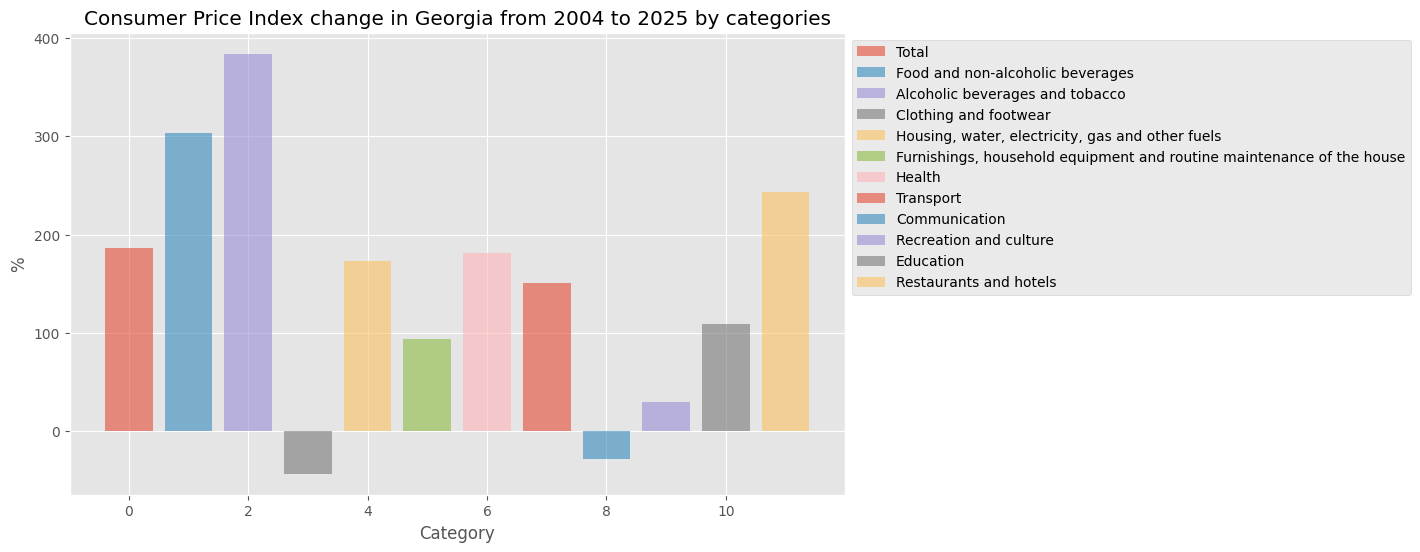

##  Inflation Rate

In [ ]:
groups_to_drop = [group for group in  df_cpi['Group'].values if group not in interested_groups]
df_inflation = df_cpi[~df_cpi["Group"].isin(groups_to_drop)]

# Subtract 100 from every value except the first column
df_inflation.iloc[:, 1:] = df_inflation.iloc[:, 1:] - 100
df_inflation.head()


x = df_inflation.columns[1:]
y = df_inflation.loc[0].values[1:]

# Compute rolling mean with a window size of 12 (adjust as needed)
rolling_mean = pd.Series(y).rolling(window=12, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(x,y,label="Inflation Rate(by month)",color='#769CDF')
ax.plot(x, rolling_mean, label='Rolling Mean (12 months)', linestyle='dashed', color='#3e4759')

indices = df_inflation.columns[1:][::36]
xtick_labels = [name[:-2] for name in indices]
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(decimals=1))

ax.set_title("inflation rate change over years in Georgia")
ax.set_xlabel("Month")
ax.set_ylabel("inflation")
plt.xticks(indices, xtick_labels)  # Select every 12th x-axis label
plt.legend()
plt.show()



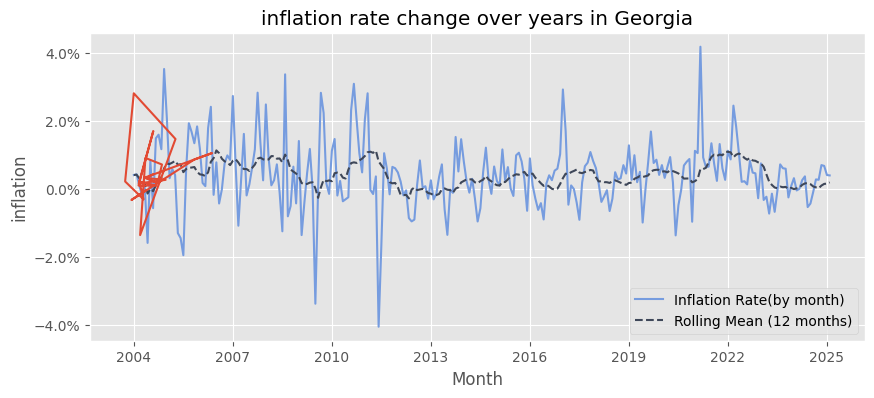

# Unemployment and Wages


## unemployment rates heatmap

In [560]:
import geopandas as gpd

# Load shapefile (replace 'georgia_shapefile.shp' with actual file)
gdf = gpd.read_file("./gadm41_GEO_shp/gadm41_GEO_1.shp")

df_employment_region_2023 = pd.read_csv('2023_employment_regions.csv')
df_employment_region_2023.rename(columns={df_employment_region_2023.columns[0]:"type"},inplace=True)
unemployment_row = df_employment_region_2023.loc[df_employment_region_2023['type'].isin(["Unemployment rate, percentage"])]

cols = list(unemployment_row.columns)[1:]
print(cols)
unemployment_values = list(unemployment_row.values[0])[1:]
print(unemployment_values)

df_unemp = pd.DataFrame({"region":cols, "rates":unemployment_values})
df_unemp = df_unemp[:-1]
df_unemp.loc[df_unemp['region'] == 'Adjara A/R', 'region'] = 'Ajaria'
df_unemp.loc[df_unemp['region'] == 'Racha-Lechkhumi and Kvemo-Svaneti', 'region'] = 'Racha-Lechkhumi-Kvemo Svaneti'
vmin = df_unemp["rates"].min(skipna=True)
vmax = df_unemp["rates"].max(skipna=True)

missing_data = pd.DataFrame({
    "region": ["Abkhazia"],  # List of missing regions
    "rates": [0.0]  # Default or estimated value
})
df_unemp = pd.concat([df_unemp,missing_data])
df_unemp_renamed = df_unemp.rename(columns={'region':'NAME_1'})
merged_data = gdf.merge(df_unemp_renamed, on="NAME_1")

['Kakheti', 'Tbilisi', 'Shida Kartli', 'Kvemo Kartli', 'Adjara A/R', 'Samegrelo-Zemo Svaneti', 'Imereti', 'Samtskhe-Javakheti', 'Guria', 'Mtskheta-Mtianeti', 'Racha-Lechkhumi and Kvemo-Svaneti', 'Georgia']
[12.0, 17.5, 16.5, 21.7, 12.2, 12.2, 20.0, 11.2, 16.1, 12.8, 17.2, 16.4]


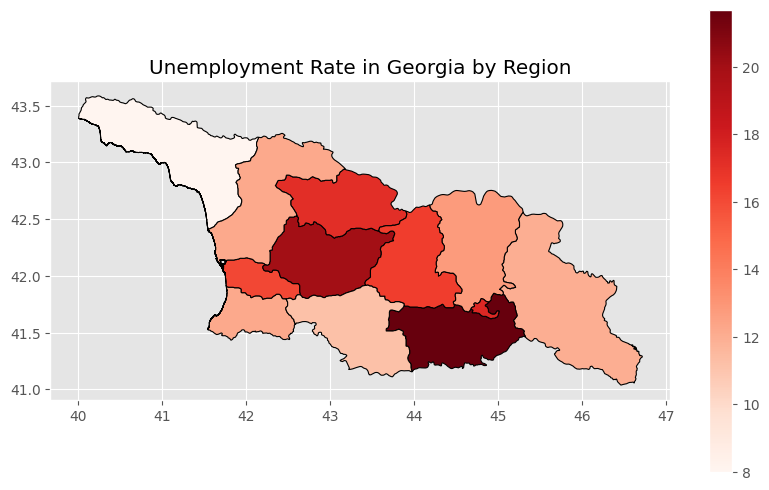

In [561]:
# Plot the heatmap
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
merged_data.plot(column="rates",
                  cmap="Reds",
                  linewidth=0.8,
                  edgecolor="black",
                  legend=True,
                  ax=ax,
                  vmin=8,
                  vmax=vmax )
ax.set_title("Unemployment Rate in Georgia by Region")
plt.show()

##

## Generate interactive map of unemployment rates

In [547]:
import folium
import json

# Convert GeoDataFrame to GeoJSON
geojson_data = merged_data.to_json()

m = folium.Map(location=[42, 43.5], zoom_start=7)

# Choropleth heatmap
folium.Choropleth(
    geo_data=geojson_data,
    name="Unemployment Rate",
    data=merged_data,
    columns=["NAME_1", "rates"],
    key_on="feature.properties.NAME_1",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.01,
    legend_name="Unemployment Rate (%)",
).add_to(m)

for _, row in merged_data.iterrows():
    # Create a Popup with specific content (region name and unemployment rate)
    popup_content = f"Region: {row['NAME_1']}<br>Unemployment Rate: {row['rates']}%"

    # Create a GeoJson object for the region
    folium.GeoJson(
        row['geometry'],  # The geometry for the region
        popup=folium.Popup(popup_content, max_width=300),
        # Optional: Customize border (line) color and width
        style_function=lambda x: {'fillColor': 'blue', 'color': 'blue', 'weight': 0}
    ).add_to(m)
# Save map to an HTML file and display
m.save("georgia_unemployment_interactive_map.html")

## salary

### Do wages in georgia keep up with inflation rates?

#### Calculate yearly Consumer Price index changes


In [567]:
# Load consumer price index chart
df_cpi = pd.read_excel('CPI.xlsx')
df_cpi.columns = df_cpi.iloc[2]
df_cpi = df_cpi[1:].reset_index(drop=True)
df_cpi.rename(columns={df_cpi.columns[0]:"Groups"},inplace=True)
row_total = df_cpi.loc[2].values[2:]

df_cpi.iloc[1,2] = 'Group'
df_cpi.columns = df_cpi.iloc[1]
df_cpi = df_cpi[4:].reset_index(drop=True)
df_cpi.drop(columns=df_cpi.columns[0],inplace=True)

new_col_names = ["Group"]
for year in range(2004,2026):
    for month in range(1,13):
        new_col_names.append(f'{year}_{month}')
print(new_col_names)
df_cpi.columns = new_col_names[:-10]

# New row to insert at index 0
row_total_df = pd.DataFrame([row_total], columns=df_cpi.columns)

# Concatenate and reset index
df_cpi = pd.concat([row_total_df, df_cpi]).reset_index(drop=True)

# String to search for
string_to_remove = "..."

# Drop rows where any column contains the string
df_cpi = df_cpi[~df_cpi.applymap(lambda x: string_to_remove in str(x)).any(axis=1)]
df_cpi = df_cpi.reset_index(drop=True)

['Group', '2004_1', '2004_2', '2004_3', '2004_4', '2004_5', '2004_6', '2004_7', '2004_8', '2004_9', '2004_10', '2004_11', '2004_12', '2005_1', '2005_2', '2005_3', '2005_4', '2005_5', '2005_6', '2005_7', '2005_8', '2005_9', '2005_10', '2005_11', '2005_12', '2006_1', '2006_2', '2006_3', '2006_4', '2006_5', '2006_6', '2006_7', '2006_8', '2006_9', '2006_10', '2006_11', '2006_12', '2007_1', '2007_2', '2007_3', '2007_4', '2007_5', '2007_6', '2007_7', '2007_8', '2007_9', '2007_10', '2007_11', '2007_12', '2008_1', '2008_2', '2008_3', '2008_4', '2008_5', '2008_6', '2008_7', '2008_8', '2008_9', '2008_10', '2008_11', '2008_12', '2009_1', '2009_2', '2009_3', '2009_4', '2009_5', '2009_6', '2009_7', '2009_8', '2009_9', '2009_10', '2009_11', '2009_12', '2010_1', '2010_2', '2010_3', '2010_4', '2010_5', '2010_6', '2010_7', '2010_8', '2010_9', '2010_10', '2010_11', '2010_12', '2011_1', '2011_2', '2011_3', '2011_4', '2011_5', '2011_6', '2011_7', '2011_8', '2011_9', '2011_10', '2011_11', '2011_12', '2012_

C:\Users\Saba\AppData\Local\Temp\ipykernel_15684\2005499525.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cpi = df_cpi[~df_cpi.applymap(lambda x: string_to_remove in str(x)).any(axis=1)]


In [608]:
df_inflation_row = inflation_for_row(df_cpi.loc[0].values)
yearly_cpi = df_inflation_row[1::12]
    

In [610]:
# we have yearly CPI, now we need to load average salaries and predict what was mean
# based on the data of last few years 

22

In [624]:
df_median_salaries = pd.read_csv('./salary_meadians.csv')
df_avg_salaries = pd.read_csv('./salaries.csv')
df_median_salaries.head()


,type,2018,2019,2020,2021,2022,2023
0,Total,700,792,809,900,1040,1238


In [625]:
df_avg_salaries.head()

,type,1970,1975,1980,1985,1986,1987,1988,1989,1990,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Total,106.1,118.9,145.2,167.6,170.6,177.2,186.9,197.7,214.0,...,818.0,900.4,940.0,999.1,1068.3,1129.5,1191.0,1304.5,1543.0,1766.8


In [650]:
# take values from averages df that are in the first df
cols_to_fetch = list(df_median_salaries.columns)[1:]
print(cols_to_fetch)

df_salaries_merged = df_avg_salaries[cols_to_fetch]
df_salaries_merged = pd.concat([df_salaries_merged, df_median_salaries],ignore_index=True)
# drop "type" column
df_salaries_merged = df_salaries_merged.drop(columns=['type'])
df_salaries_merged.reset_index()

['2018', '2019', '2020', '2021', '2022', '2023']


,index,2018,2019,2020,2021,2022,2023
0,0,1068.3,1129.5,1191.0,1304.5,1543.0,1766.8
1,1,700.0,792.0,809.0,900.0,1040.0,1238.0


In [651]:
print(df_salaries_merged)


     2018    2019    2020    2021    2022    2023
0  1068.3  1129.5  1191.0  1304.5  1543.0  1766.8
1   700.0   792.0   809.0   900.0  1040.0  1238.0


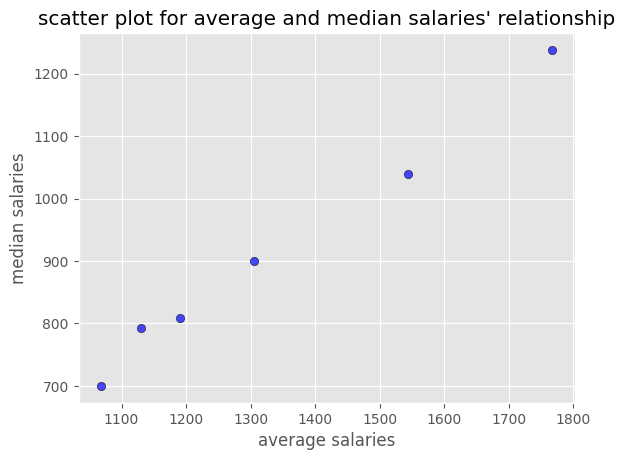

In [658]:
x = df_salaries_merged.loc[0]
y = df_salaries_merged.loc[1]

plt.scatter(x, y, color='blue', alpha=0.7, edgecolors='black')


plt.xlabel("average salaries")
plt.ylabel("median salaries")
plt.title("scatter plot for average and median salaries' relationship")


plt.show()

In [659]:
# Calculate correlation coefficient to be sure that they have correlation
correlation = np.corrcoef(x, y)[0, 1]
print(f"Correlation coefficient: {correlation:.4f}")

Correlation coefficient: 0.9949


In [669]:
# it seems like they have strong correlation and now we need to make simple linear regression model to fit this data
from sklearn.linear_model import LinearRegression

X = np.array(x.values).reshape(-1, 1)
Y = np.array(y.values)
# we make linear regression model to predict previous years' data
model = LinearRegression()
model.fit(X,Y)

# Print model coefficients
print(f"Intercept: {model.intercept_:.2f}")
print(f"Slope: {model.coef_[0]:.2f}")

r2_score = model.score(X, Y)
print(f"R² Score: {r2_score:.4f}")

Intercept: -51.56
Slope: 0.72
R² Score: 0.9899


In [685]:
# we should drop really old data i.e 1970-2003
columns_to_drop = [str(year) for year in range(1985,2004)]
columns_to_drop = columns_to_drop + list(df_avg_salaries.columns[:4].values)
columns_to_drop = sorted(columns_to_drop)

df_avg_salaries = df_avg_salaries.drop(columns=columns_to_drop)

In [692]:
predictions = model.predict(df_avg_salaries.loc[0].values.reshape(-1,1))
df_pred = pd.DataFrame([predictions],columns=df_avg_salaries.columns)

In [695]:
df_avg_salaries = pd.concat([df_avg_salaries,df_pred],ignore_index=True)

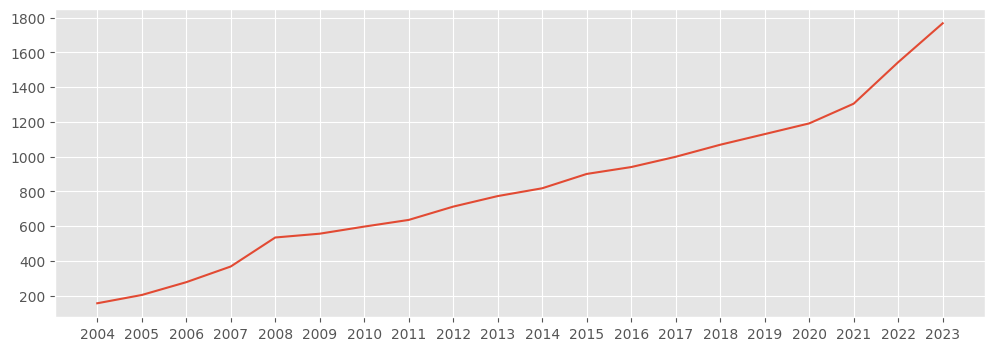

In [773]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(df_avg_salaries.columns,df_avg_salaries.loc[0])
plt.show()

In [ ]:
# now we have median salaries data for years 2004-2023 and we should find if salaries keep up with inflation
inflation_rate_over_years = []

year_starts = list(df_price_changes.loc[0][1::12])
year_ends = list(df_price_changes.loc[0][12::12])


for i in range(len(year_ends)):
    inflation_rate_over_years.append((year_ends[i]-year_starts[i]) 
                                     / year_starts[i]  * 100 )
    

In [814]:
# we should convert median nominal wages to real wages
wages = list(df_avg_salaries.loc[0])
real_wages = []
for idx in range(len(wages)):
    real_wages.append(wages[idx] / year_ends[idx]  * 100)
print(real_wages)

[145.6972563413313, 178.9273694951798, 223.85542725388262, 267.1906259893153, 367.8568718154, 371.8143671535584, 358.7380570050173, 374.15264329210953, 424.99396553955427, 450.4547703391098, 467.492107750628, 490.64297526738886, 503.0061913464328, 500.98414883559883, 527.6884134623251, 521.4361402841287, 536.9172033099971, 516.1365781202488, 555.7724503897591, 633.6129028691038]


In [815]:
wage_old = real_wages
wage_new = real_wages[1:]
wage_growth_rate = []

for i in range(len(wage_new)):
    wage_growth_rate.append((wage_new[i]-wage_old[i]) 
                                     / wage_old[i]  * 100 )

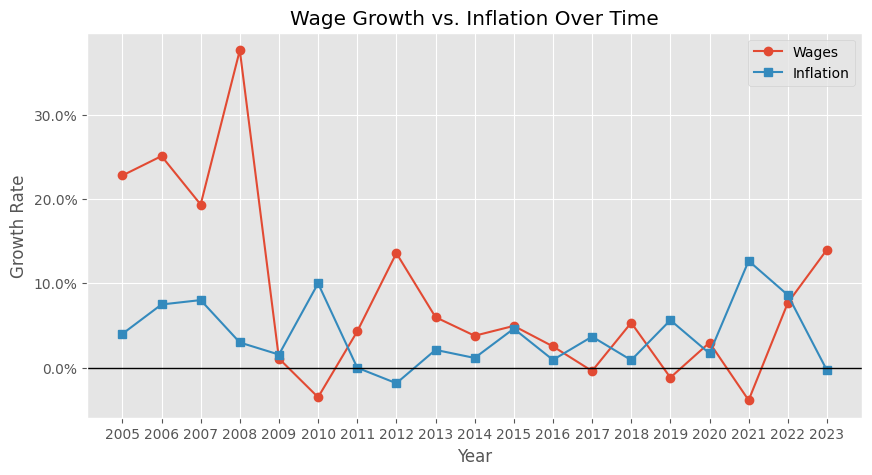

In [816]:
fig, ax = plt.subplots(figsize=(10,5))
years = df_avg_salaries.columns[1:]

ax.plot(years, wage_growth_rate,marker='o', label='Wages')
ax.plot(years, inflation_rate_over_years[1:-1],marker='s',label="Inflation")


plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(decimals=1))

plt.axhline(y=0, color='black', linewidth=1)

ax.set_title("Wage Growth vs. Inflation Over Time")
ax.set_xlabel("Year")
ax.set_ylabel("Growth Rate")
plt.legend()
plt.show()


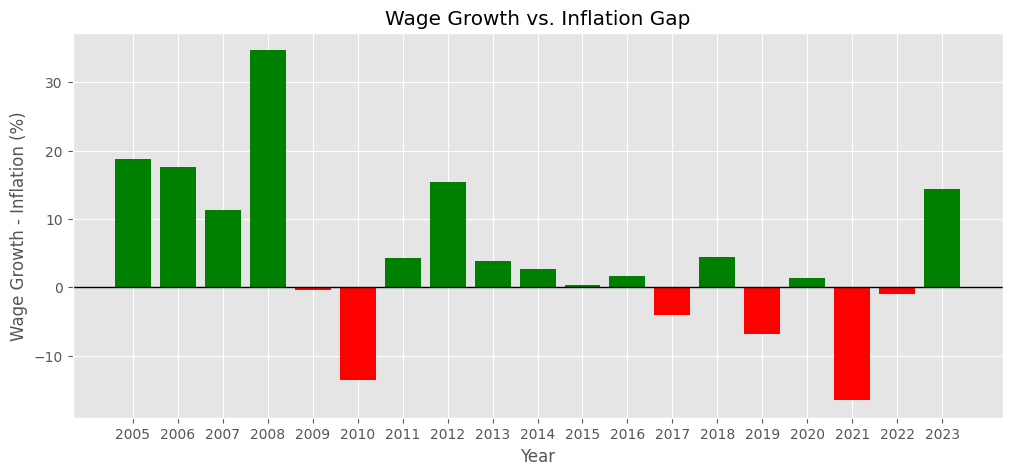

In [ ]:
gaps = np.array(wage_growth_rate) - np.array(inflation_rate_over_years[1:-1])

plt.figure(figsize=(12, 5))
plt.bar(years, gaps, color=['green' if g > 0 else 'red' for g in gaps])

plt.axhline(y=0, color='black', linewidth=1)

plt.xlabel("Year")
plt.ylabel("Wage Growth - Inflation (%)")
plt.title("Wage Growth vs. Inflation Gap")
plt.show()